In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import py7zr

In [2]:
plt.style.use('ggplot')

In [3]:
spectr_dir = 'spectr_data'
zip_file_path = 'spectrums.7z'

os.makedirs(spectr_dir, exist_ok=True)

with py7zr.SevenZipFile(zip_file_path, mode='r') as archive:
    archive.extractall(path=spectr_dir)

In [4]:
cu_data = pd.read_csv('Cu_conc_in_spectrum.txt',
                      sep=' ', header=None, skiprows=1)
cu_data.columns = ['Concentration', 'FileName']
cu_data['FileName'] = cu_data['FileName'].apply(
    lambda x: str(x).split('.')[0] + '.mca')
cu_data.head(3)

,Concentration,FileName
0,1.75,67.mca
1,1.47,74.mca
2,1.39,83.mca


In [5]:
windows = pd.read_csv('elements_windows.txt', sep=' ',
                      header=None, names=['Element', 'E1', 'E2'])
windows.head()

,Element,E1,E2
0,S,81,87
1,Ag,105,113
2,Cr,195,201
3,Fe_Ka,227,244
4,Fe_Kb,252,267


In [6]:
def parse_mca(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()
        data_start = False
        spectrum = []
        for line in lines:
            stripped_line = line.strip()
            if data_start:
                if stripped_line == "<<END>>":
                    break
                try:
                    spectrum.append(int(stripped_line))
                except ValueError:
                    continue
            if stripped_line == "<<DATA>>":
                data_start = True
        return np.array(spectrum)

In [7]:
spectra = {}
for filename in cu_data['FileName']:
    filepath = os.path.join(spectr_dir, filename)
    if os.path.exists(filepath):
        spec = parse_mca(filepath)
        if spec is not None:
            spectra[filename] = spec

In [8]:
df = cu_data.copy()
df['Spectrum'] = df['FileName'].map(spectra)
df = df.dropna()

for index, row in windows.iterrows():
    element = row['Element']
    ch1 = row['E1']
    ch2 = row['E2']
    df[element] = df['Spectrum'].apply(lambda x: np.sum(
        x[ch1:ch2+1]) if ch1 < len(x) and ch2 < len(x) else 0)

In [9]:
df

,Concentration,FileName,Spectrum,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,...,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,1.75,67.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 159, 135, ...",564,619,507,175146,34601,298,543,...,1000,17793,2921,61152,11857,5779,6610,840,71341,15937
1,1.47,74.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 116, 103, 1...",353,464,578,240049,46711,207,548,...,1010,17752,2809,76044,14302,6143,6257,1035,38793,10534
2,1.39,83.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 78, 102, 105, 1...",379,501,591,237181,46446,208,566,...,1000,15732,2668,74421,14078,6057,5979,1046,38853,10657
3,2.46,91.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 114, 116, 8...",391,423,575,244355,47629,205,595,...,969,20209,3250,75650,14398,6321,6280,1084,38308,10379
4,2.20,99.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 120, 84, 11...",354,456,561,236772,46218,220,627,...,976,18357,2888,75961,14267,6100,6354,984,38525,10400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1.26,8401.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 131, 126, ...",421,484,451,188130,37009,213,446,...,827,11637,2028,58171,11360,5700,5289,840,46608,11742
197,1.37,8405.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 102, 117, 147, ...",450,548,456,181850,35646,221,442,...,889,12883,2091,56732,10910,5715,5435,888,50067,12133
198,1.13,8415.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 132, 131, ...",416,497,508,189629,37204,265,451,...,793,10708,1918,59269,11321,6048,5582,854,46895,11557
199,1.16,8422.mca,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 117, 128, 122, ...",472,508,457,185961,36578,261,436,...,906,11425,1965,57827,11189,5968,5635,944,48798,12102


In [10]:
from sklearn.model_selection import train_test_split

features = windows['Element'].tolist()
X = df[features]
y = df['Concentration']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [11]:
training_data = [(np.array(x).reshape(-1, 1), y)
                 for x, y in zip(X_train.values.tolist(), y_train.values.tolist())]
test_data = [(np.array(x).reshape(-1, 1), y)
             for x, y in zip(X_test.values.tolist(), y_test.values.tolist())]

In [12]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        epoch_losses = []

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k + mini_batch_size]
                            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            epoch_loss = self.calculate_loss(training_data)
            epoch_losses.append(epoch_loss)

        return epoch_losses

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) *
                        nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b,
                       nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = self.cost_derivative(
            activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

    def sigmoid(self, z):
        """The sigmoid function."""
        return 1.0/(1.0+np.exp(-z))

    def sigmoid_prime(self, z):
        """Derivative of the sigmoid function."""
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def calculate_loss(self, data):
        loss = 0
        for x, y in data:
            output = self.feedforward(x)
            loss += np.sum((output - y) ** 2)
        return loss / len(data)

In [13]:
net = Network([len(features), 10, 1])
epoch_losses = net.SGD(training_data, epochs=100,
                       mini_batch_size=20, eta=0.01, test_data=test_data)

C:\Users\matsvei\AppData\Local\Temp\ipykernel_16412\624171229.py:81: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


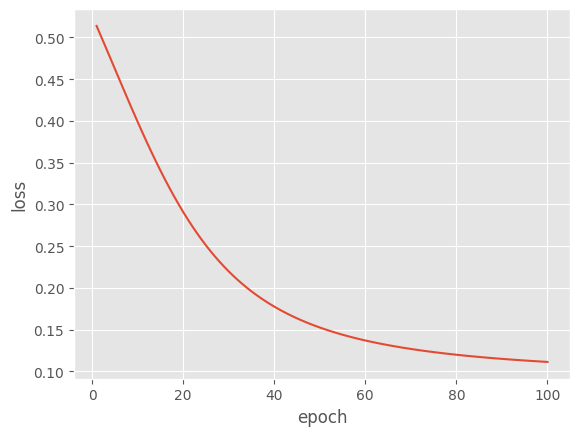

In [14]:
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
test_results = [(net.feedforward(x), y) for (x, y) in test_data]
predicted = [result[0][0] for result in test_results]
actual = [result[1] for result in test_results]

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.17859436538063628


C:\Users\matsvei\AppData\Local\Temp\ipykernel_16412\624171229.py:81: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


: 